Comenzando el entrenamiento de pesos...


100%|██████████| 3/3 [00:00<00:00, 4329.98it/s]


Comenzando la predicción...


100%|██████████| 3/3 [00:00<00:00, 4029.11it/s]


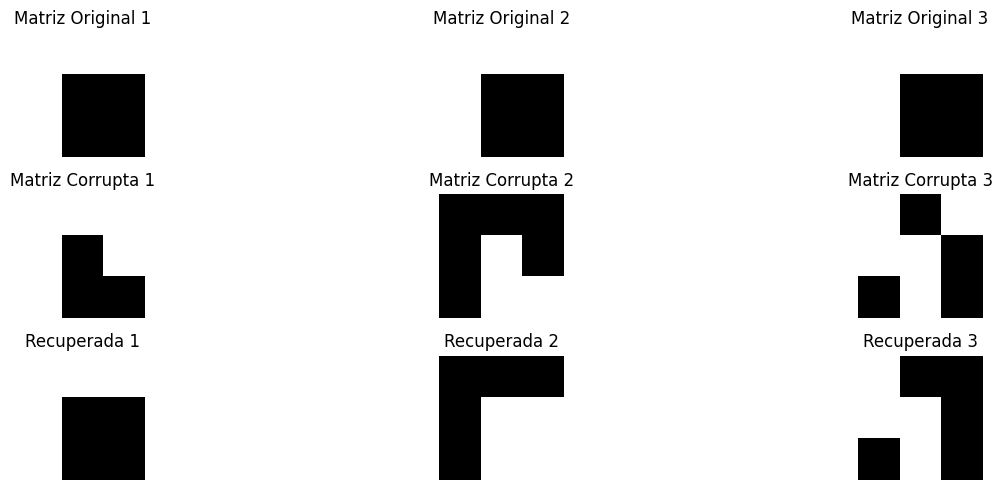

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm

class RedHopfield(object):
    def entrenar_pesos(self, datos_entrenamiento):
        print("Comenzando el entrenamiento de pesos...")
        num_datos = len(datos_entrenamiento)
        self.num_neuronas = datos_entrenamiento[0].shape[0]

        # Inicializar los pesos
        W = np.zeros((self.num_neuronas, self.num_neuronas))
        rho = np.sum([np.sum(t) for t in datos_entrenamiento]) / (num_datos * self.num_neuronas)

        # Regla de Hebb
        for i in tqdm(range(num_datos)):
            t = datos_entrenamiento[i] - rho
            W += np.outer(t, t)

        # Hacer que los elementos diagonales de W sean 0
        diagW = np.diag(np.diag(W))
        W = W - diagW
        W /= num_datos

        self.W = W

    def predecir(self, datos, num_iter=20, umbral=0, asincronico=False):
        print("Comenzando la predicción...")
        self.num_iter = num_iter
        self.umbral = umbral
        self.asincronico = asincronico

        # Copiar para evitar referencias
        datos_copiados = np.copy(datos)

        # Definir lista de predicciones
        predicciones = []
        for i in tqdm(range(len(datos))):
            predicciones.append(self._ejecutar(datos_copiados[i]))
        return predicciones

    def _ejecutar(self, estado_inicial):
        if self.asincronico == False:
            """
            Actualización síncrona
            """
            # Calcular la energía inicial del estado
            s = estado_inicial
            e = self.energia(s)

            # Iteración
            for i in range(self.num_iter):
                # Actualizar s
                s = np.sign(self.W @ s - self.umbral)
                # Calcular la nueva energía del estado
                e_nueva = self.energia(s)

                # s ha convergido
                if e == e_nueva:
                    return s
                # Actualizar la energía
                e = e_nueva
            return s
        else:
            """
            Actualización asincrónica
            """
            # Calcular la energía inicial del estado
            s = estado_inicial
            e = self.energia(s)

            # Iteración
            for i in range(self.num_iter):
                for j in range(100):
                    # Seleccionar una neurona aleatoria
                    idx = np.random.randint(0, self.num_neuronas)
                    # Actualizar s
                    s[idx] = np.sign(self.W[idx].T @ s - self.umbral)

                # Calcular la nueva energía del estado
                e_nueva = self.energia(s)

                # s ha convergido
                if e == e_nueva:
                    return s
                # Actualizar la energía
                e = e_nueva
            return s

    def energia(self, s):
        return -0.5 * s @ self.W @ s + np.sum(s * self.umbral)

    def graficar_pesos(self):
        plt.figure(figsize=(6, 5))
        matriz_w = plt.imshow(self.W, cmap='coolwarm')
        plt.colorbar(matriz_w)
        plt.title("Pesos de la Red")
        plt.tight_layout()
        plt.savefig("pesos.png")
        plt.show()

# Crear instancias de la red de Hopfield
red_hopfield = RedHopfield()

# Crear tres matrices originales (patrones de entrenamiento)
matriz_original1 = np.array([[1, 1, 1],
                            [1, -1, -1],
                            [1, -1, -1]])

matriz_original2 = np.array([[-1, -1, -1],
                            [-1, 1, 1],
                            [-1, 1, 1]])

matriz_original3 = np.array([[1, -1, -1],
                            [1, 1, -1],
                            [-1, 1, -1]])

# Crear tres matrices con ruido (matrices corruptas)
matriz_corrupta1 = np.array([[1, 1, 1],
                            [1, -1, 1],    # Se ha corrompido un valor
                            [1, -1, -1]])

matriz_corrupta2 = np.array([[-1, -1, -1],
                            [-1, 1, -1],    # Se ha corrompido un valor
                            [-1, 1, 1]])

matriz_corrupta3 = np.array([[1, -1, 1],     # Se ha corrompido un valor
                            [1, 1, -1],
                            [-1, 1, -1]])

# Crear un conjunto de datos de entrenamiento con las matrices originales
datos_entrenamiento = [matriz_original1.flatten(), matriz_original2.flatten(), matriz_original3.flatten()]

# Entrenar la red de Hopfield con los datos de entrenamiento
red_hopfield.entrenar_pesos(datos_entrenamiento)

# Crear un conjunto de datos de prueba con las matrices corruptas
datos_prueba = [matriz_corrupta1.flatten(), matriz_corrupta2.flatten(), matriz_corrupta3.flatten()]

# Intentar recuperar las matrices corruptas utilizando la red de Hopfield
resultados = red_hopfield.predecir(datos_prueba)

# Graficar las matrices originales y las recuperadas
plt.figure(figsize=(15, 5))
for i in range(len(datos_prueba)):
    plt.subplot(3, len(datos_prueba), i + 1)
    plt.imshow(matriz_original1, cmap='gray')
    plt.title('Matriz Original {}'.format(i + 1))
    plt.axis('off')

    plt.subplot(3, len(datos_prueba), i + len(datos_prueba) + 1)
    plt.imshow(datos_prueba[i].reshape(3, 3), cmap='gray')
    plt.title('Matriz Corrupta {}'.format(i + 1))
    plt.axis('off')

    plt.subplot(3, len(datos_prueba), i + 2 * len(datos_prueba) + 1)
    plt.imshow(resultados[i].reshape(3, 3), cmap='gray')
    plt.title('Recuperada {}'.format(i + 1))
    plt.axis('off')

plt.tight_layout()
plt.show()
